# Introduction
Let's create the class Convolutional Neural Network (CNN) from scratch. We will implement the algorithm using only the minimum library such as NumPy.


In this Sprint, we will build a 1D Convolutional layer and try to understand the basics of convolution. The next Sprint completes the CNN commonly used for images by creating a two-dimensional convolutional layer and a pooling layer.


Name the class Scratch1dCNNClassifier. Please refer to the ScratchDeepNeuralNetrowkClassifier created in the previous Sprint for the class structure.



In [157]:
#needed
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Needed Old Code

In [158]:
#intializer
class SimpleInitializer:
  def __init__(self, sigma = 0.1):
    self.sigma = sigma
  def W(self, n_nodes1, n_nodes2):
    W = self.sigma * np.random.randn(n_nodes1,n_nodes2)
    return W
  def B(self, n_nodes2):

    B = self.sigma * np.random.randn(1,n_nodes2)
    return B
class SGD:
    """
    Stochastic gradient descent
    Parameters
    ----------
    lr : Learning rate
    """
    def __init__(self, lr=0.01):
        self.lr = lr
    def update(self, layer):
        """
        Update weights and biases for a layer
        Parameters
        ----------
        layer : Instance of the layer before update
        """
        #update
        layer.B += - self.lr * layer.dB
        layer.W += - self.lr * layer.dW
        return layer
#! mini batch...........................
class GetMiniBatch:
    """
Iterator to get a mini-batch
    Parameters
    ----------
    X : The following forms of ndarray, shape (n_samples, n_features)
      Training data
    y : The following form of ndarray, shape (n_samples, 1)
      Correct answer value
    batch_size : int
      Batch size
    seed : int
      NumPy random number seed
    """
    def __init__(self, X, y = None, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index] if y is not None else None
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        if self._y is not None:
          return self._X[p0:p1], self._y[p0:p1] 
        else:
          return self._X[p0:p1]       
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        if self._y is not None:
          return self._X[p0:p1], self._y[p0:p1] 
        else:
          return self._X[p0:p1]

# Problem 1
1 Dim convolutional Layer that limit number of channels to 1

## Forward

In [159]:
class SimpleConv1D:
  def __init__(self, filter_size, initializer, optimizer):
    # Initialize
    self.optimizer = optimizer
    self.filter_size = filter_size
    # Initialize self.W and self.B using the initializer method
    self.W = initializer.W(filter_size, 1)
    self.B = initializer.B(1)
  def forward(self, X):
    filter_size = self.filter_size
    self.X = X
    return self.convolve(self.W,X, bias = self.B)

  def backward(self, dA):
    # update
    self.dA = dA
    self.dW = self.calc_dW()
    self.dB = self.calc_dB()
    self.dX = self.calc_dX()
    self = self.optimizer.update(self)
    return self.dW, self.dB, self.dX
  def calc_dW(self):
    return self.convolve(self.dA, self.X)
  def calc_dB(self):
    return np.array(self.dA.sum()).ravel()
  def calc_dX(self):
    padA = self.padA()
    return self.convolve(np.flip(self.W),padA)
  def padA(self):
    padding = (len(self.X) - 1 + len(self.W) - len(self.dA)) //2 # cause out = (in - fil + 2pad) + 1
    print('Padding size: ', padding)
    return np.pad(self.dA,(padding, padding), mode = 'constant')
  def convolve(self,F,X,bias = [0]):
    A = []
    filter_size = len(F)
    for i in range(len(X) - filter_size + 1):
      A.append(X[i : i + filter_size] @ F + bias[0])
    return np.array(A)

    
  

# Problem 2
Output size calculation

In [160]:
def conv_n_out(n_in,filter_size, padding=0, stride=1):
    return (n_in + 2*padding - filter_size) //stride + 1
print('Convolutional n-out of input 30 and filter 3:', conv_n_out(30,3))

Convolutional n-out of input 30 and filter 3: 28


# Problem 3
Experiment of one-dimensional convolutional layer with small array

In [161]:
x = np.array([1,2,3,4])
w = np.array([3, 5, 7], dtype = np.float64)
b = np.array([1], dtype = np.float64)
layer = SimpleConv1D(3,SimpleInitializer(),SGD())
layer.W = w
layer.B = b

print('n_output: ', conv_n_out(len(x),len(w)))

correct_forward_result = np.array([35, 50])
a = layer.forward(x)
print('forward: ', layer.forward(x), 'correct result: ', correct_forward_result)


delta_a = np.array([10, 20])
dW,dB,dX = layer.backward(delta_a)


correct_delta_b = np.array([30])
correct_delta_x = np.array([30, 110, 170, 140])
correct_delta_w = np.array([50, 80, 110])
print('dB: ', dB, 'correct result: ', correct_delta_b)
print('dW: ', dW,'correct result: ', correct_delta_w)
print('dX: ', dX, 'correct result: ', correct_delta_x)

n_output:  2
forward:  [35. 50.] correct result:  [35 50]
Padding size:  2
dB:  [30] correct result:  [30]
dW:  [ 50  80 110] correct result:  [ 50  80 110]
dX:  [ 30. 110. 170. 140.] correct result:  [ 30 110 170 140]


# Problem 4
Creating a one-dimensional convolutional layer class that does not limit the number of channels

# Updated Prototype (NO STRIDE, NO BATCH)

In [162]:
class Conv1D:
  def __init__(self, filter_size = 3, n_input = 2, n_output = 3, optimizer = SGD(), padding = 0):
    # Initialize
    self.optimizer = optimizer
    self.filter_size = filter_size
    # Initialize self.W and self.B using the initializer method
    self.filter_size = filter_size
    self.n_input = n_input
    self.n_output = n_output

    self.W = np.ones((n_output, n_input,filter_size))
    self.B = np.ones(n_output)
    #padding and stride
    self.padding = padding
  def forward(self, X): 
    X = np.pad(X,[(0,0),(self.padding, self.padding)], mode = 'constant')
    self.X = X
    output = []
    for i in range(self.n_output):
      filt = self.W[i]
      bias = self.B[i]
      conv = self.convolve(filt, X)
      output.append(conv.sum(axis = 0) + bias)
    return np.array(output)
  def backward(self, dA):
    # update
    self.dA = dA
    self.dW = self.calc_dW()
    self.dB = self.calc_dB()
    self.dX = self.calc_dX()
    self = self.optimizer.update(self)
    # print(f'After backward: x {self.X.shape}, w: {self.W.shape}, b: {self.B.shape}, dX: {self.dX.shape}, dW: {self.dW.shape}, dB: {self.dB.shape}, dA: {self.dA.shape}')
    # print(f'filterz: {self.filter_size}')
    return self.dW, self.dB, self.dX
  def calc_dW(self):
    dW = []
    dupped_dA = np.repeat(self.dA[:,np.newaxis, : ], self.n_input, axis=1)
    for i in range(self.n_output): #convolve each output_channel through X
      conv = self.convolve(dupped_dA[i], self.X)
      dW.append(conv) 
    return np.array(dW)
  def calc_dB(self):
    return np.array(self.dA.sum(axis = 1))
  def calc_dX(self):
    pad_dA = self.pad_dA() #match a with x
    flipped_W = np.flip(self.W,axis = 2).reshape(self.n_input,self.n_output, -1) # flip each filter and the in_out dim also
    output = []
    for i in range(self.n_input):
      filt = flipped_W[i]
      conv = self.convolve(filt, pad_dA)
      output.append(conv.sum(axis = 0))
    return np.array(output)
  def pad_dA(self):
    n_features_in = self.dA.shape[1]
    n_features_out = self.X.shape[1]
    filter_size = self.filter_size
    padding = (n_features_out - 1 + filter_size - n_features_in) // 2
    return self.pad(self.dA, padding)
  def pad(self,array,padding):
    return np.pad(array,[(0,0),(padding, padding)], mode = 'constant')
  def convolve(self,F,X):
    A = []
    filter_size = F.shape[1]
    feature_count = X.shape[1]
    n_out_features = (feature_count - filter_size) + 1
    for i in range(n_out_features):
      A.append((X[:,i : i + filter_size] * F).sum(axis=1))
    return np.array(A).T

## Forward

In [163]:
x = np.array([[1, 2, 3, 4], [2, 3, 4, 5]]) #shape (2, 4), (number of input channels, number of features).
# x = np.array([[1, 2, 3], [3, 4, 5]]) #shape (2, 4), (number of input channels, number of features).
w = np.ones((3, 2, 3)) # Set to 1 for simplification of the example. (Number of output channels, number of input channels, filter size).
b = np.array([1, 2, 3]) # (Number of output channels)

conv = Conv1D(3,2,3)
conv.B = b
print(conv.forward(x))
print('correct: result: ',np.array([[16, 22], [17, 23], [18, 24]]))

[[16. 22.]
 [17. 23.]
 [18. 24.]]
correct: result:  [[16 22]
 [17 23]
 [18 24]]


## Let's user problem 3 as a reference to make the multichannel propagation

In [164]:
x = np.array([1,2,3,4])
w = np.array([3, 5, 7], dtype = np.float64)
filter_size, n_input,n_output = 3,2,3
# print('f,nin,nout: ', filter_size, n_input,n_output)
layer = Conv1D()
x = np.vstack([x] * n_input)
w = np.vstack([[np.vstack([w]*n_input)]] * n_output)
b = np.ones(n_output)
layer.W = w
layer.B = b

print('X: ', x)
print('w: ', w)
print('b: ', b)

correct_forward_result = np.array([35, 50])
a = layer.forward(x)
print('forward: ', layer.forward(x), 'correct result: ', correct_forward_result)


delta_a = np.vstack([[10, 20]]* n_output)
layer.dA = delta_a
dW = layer.calc_dW()
dB = layer.calc_dB()
dX = layer.calc_dX()

print('dB: ', dB, 'correct result: ', correct_delta_b)
print('dW: ', dW,'correct result: ', correct_delta_w)
print('dX: ', dX, 'correct result: ', correct_delta_x)

X:  [[1 2 3 4]
 [1 2 3 4]]
w:  [[[3. 5. 7.]
  [3. 5. 7.]]

 [[3. 5. 7.]
  [3. 5. 7.]]

 [[3. 5. 7.]
  [3. 5. 7.]]]
b:  [1. 1. 1.]
forward:  [[69. 99.]
 [69. 99.]
 [69. 99.]] correct result:  [35 50]
dB:  [30 30 30] correct result:  [30]
dW:  [[[ 50  80 110]
  [ 50  80 110]]

 [[ 50  80 110]
  [ 50  80 110]]

 [[ 50  80 110]
  [ 50  80 110]]] correct result:  [ 50  80 110]
dX:  [[ 90. 330. 510. 420.]
 [ 90. 330. 510. 420.]] correct result:  [ 30 110 170 140]


# Problem 5
Implement Padding

### Note: padding added in prototype

In [165]:
#padding example
def add_padding(X, padding_size):
    return np.pad(X, ((0,0),(padding_size,padding_size)), mode = 'constant', constant_values = 0)

#we are conv 1d so just pad horizontally
print(f'x: {x}')
print(f'padded:\n {add_padding(x, 3)}')

x: [[1 2 3 4]
 [1 2 3 4]]
padded:
 [[0 0 0 1 2 3 4 0 0 0]
 [0 0 0 1 2 3 4 0 0 0]]


In [166]:
# test run on prototype just to see if it works
padded_layer = Conv1D(padding = 2)
a = padded_layer.forward(x)
dW,dB,dX = padded_layer.backward(a)
print('shapes: ', dW.shape,dB.shape,dX.shape)

shapes:  (3, 2, 3) (3,) (2, 8)


# Problem 6
Response to mini batch

### NOTE
Currently, our layer only works with one sample with many layers

**Let's add many samples**


# Batch Prototype

In [167]:
class ConvInitializer:
  def __init__(self, sigma = 0.1):
    self.sigma = sigma
  def W(self, n_output, n_input, filter_size):
    W = self.sigma * np.random.randn(n_output, n_input, filter_size)
    return W
  def B(self, n_output):

    B = self.sigma * np.random.randn(n_output)
    return B

In [168]:
class Conv1DBatch:
  def __init__(self, filter_size = 3, n_input = 2, n_output = 3, optimizer = SGD(), initializer = ConvInitializer(), padding = 0):
    # Initialize
    self.optimizer = optimizer
    self.filter_size = filter_size
    # Initialize self.W and self.B using the initializer method
    self.filter_size = filter_size
    self.n_input = n_input
    self.n_output = n_output

    if initializer == None:
      self.W = np.ones((n_output, n_input,filter_size))
      self.B = np.ones(n_output)
    else:
      self.W = initializer.W(n_output, n_input, filter_size)
      self.B = initializer.B(n_output)
    #padding and stride
    self.padding = padding
        
  def forward(self,X): #! NOTE: X must be 3 dimensional (batch_size, channel_count, feature_count)
    self.batch_size = len(X)
    X = np.pad(X,[(0,0),(0,0),(self.padding, self.padding)], mode = 'constant')
    self.X = X
    result = []
    for x in self.X:
      result.append(self._forward_sample(x))
    # print('forward: ', np.array(result).shape)
    return np.array(result)
  def _forward_sample(self,X):    
    output = []
    for i in range(self.n_output):
      filt = self.W[i]
      bias = self.B[i]
      conv = self.convolve(filt, X)
      output.append(conv.sum(axis = 0) + bias)
    return np.array(output)

  def backward(self, dA):
    # update
    self.dA = dA
    self.dX = []

    for i in range(self.batch_size):
      self.dW = self.calc_dW(i)
      self.dB = self.calc_dB(i)
      self.dx = self.calc_dx(i)
      self = self.optimizer.update(self)
      self.dX.append(self.dx) #! keep updating while calculating error for prev layer
      # print('dx: ', i, self.dx.shape,self.dx)
    self.dX = np.array(self.dX)
    return self.dW, self.dB , self.dX
    

  def calc_dW(self,sample_index):
    dW = []
    dupped_dA = np.repeat(self.dA[sample_index][:,np.newaxis, : ], self.n_input, axis=1)
    for i in range(self.n_output): #convolve each output_channel through X
      conv = self.convolve(dupped_dA[i], self.X[sample_index])
      dW.append(conv) 
    return np.array(dW)
  def calc_dB(self,sample_index):
    return np.array(self.dA[sample_index].sum(axis = 1))

  def calc_dx(self, sample_index): #! careful
    pad_dA = self.pad_dA(sample_index) #match a with x
    flipped_W = np.flip(self.W,axis = 2).reshape(self.n_input,self.n_output, -1) # flip each filter and the in_out dim also
    output = []
    for i in range(self.n_input):
      filt = flipped_W[i]
      conv = self.convolve(filt, pad_dA)
      output.append(conv.sum(axis = 0))
    return np.array(output)
  def pad_dA(self,sample_index):
    array = self.dA[sample_index]
    n_features_in = array.shape[1]
    n_features_out = self.X.shape[-1]
    filter_size = self.filter_size
    padding = (n_features_out - 1 + filter_size - n_features_in) // 2
    return self.pad(array, padding)
  def pad(self,array,padding):
    return np.pad(array,[(0,0),(padding, padding)], mode = 'constant')
  def convolve(self,F,X):
    A = []
    filter_size = F.shape[-1]
    feature_count = X.shape[-1]
    n_out_features = (feature_count - filter_size) + 1
    for i in range(n_out_features):
      A.append((X[...,i : i + filter_size] * F).sum(axis=-1))
    return np.array(A).T

# layer = Conv1DBatch(padding = 2)
# X = np.array([[[1,2,3],[4,5,6]], [[2,3,4],[5,6,7]]])
# layer.B = np.array([1,2,3])
# fr = layer.forward(X)
# print(fr.shape, fr)

In [170]:

#batch test
x = np.array([1,2,3,4])
w = np.array([3, 5, 7], dtype = np.float64)
filter_size, n_input,n_output = 3,2,3
# print('f,nin,nout: ', filter_size, n_input,n_output)
layer = Conv1DBatch(filter_size = filter_size, n_input = n_input, n_output =n_output)
x = np.vstack([x] * n_input)
w = np.vstack([[np.vstack([w]*n_input)]] * n_output)
b = np.ones(n_output)
layer.W = w
layer.B = b

#add dim
batch_size = 2
x = np.vstack([[x]] * batch_size)

print(x.shape,x)
fr = layer.forward(x)
print(fr)

delta_a = np.vstack([[10, 20]]* n_output)
delta_a = np.vstack([[delta_a]] * batch_size)
# layer.dA = delta_a
print('delta_a: ', delta_a.shape, delta_a)
dW,dB,dX = layer.backward(delta_a)

print('dB: ', dB, 'correct result: ', correct_delta_b)
print('dW: ', dW,'correct result: ', correct_delta_w)
print('dX: ', dX, 'correct result: ', correct_delta_x)

(2, 2, 4) [[[1 2 3 4]
  [1 2 3 4]]

 [[1 2 3 4]
  [1 2 3 4]]]
[[[69. 99.]
  [69. 99.]
  [69. 99.]]

 [[69. 99.]
  [69. 99.]
  [69. 99.]]]
delta_a:  (2, 3, 2) [[[10 20]
  [10 20]
  [10 20]]

 [[10 20]
  [10 20]
  [10 20]]]
dB:  [30 30 30] correct result:  [30]
dW:  [[[ 50  80 110]
  [ 50  80 110]]

 [[ 50  80 110]
  [ 50  80 110]]

 [[ 50  80 110]
  [ 50  80 110]]] correct result:  [ 50  80 110]
dX:  [[[ 90. 330. 510. 420.]
  [ 90. 330. 510. 420.]]

 [[ 75. 276. 429. 354.]
  [ 75. 276. 429. 354.]]] correct result:  [ 30 110 170 140]


# Modified Copy Old Code

In [171]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score


#! activations..............

class ActivationFunction():
  def forward(self,A):
    pass
  def backward(self,dZ):
    pass
class Tanh(ActivationFunction):
  def forward(self,A):
    self.A = A
    Z = (np.exp(A) - np.exp(-A)) / (np.exp(A) + np.exp(-A))
    return Z
  def backward(self,dZ):
    A = self.A
    dA = dZ * (1 - np.tanh(A) ** 2)
    return dA
  
class SoftMax(ActivationFunction):
  def forward(self,A):
    self.A = A
    Z = np.exp(A) / np.sum(np.exp(A), axis = 1).reshape(-1,1)
    return Z
  def backward(self,Z,Y):
    A = self.A
    nb = Z.shape[0]
    dA = 1/nb * (Z - Y)
    return dA

#! Full Connected Layer ...........................

class FC:
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        # Initialize
        self.optimizer = optimizer
        self.n_nodes1, self.n_nodes2 = n_nodes1, n_nodes2
        # Initialize self.W and self.B using the initializer method
        self.W = initializer.W(n_nodes1, n_nodes2)
        self.B = initializer.B(n_nodes2)
        pass
    def forward(self, X):   
        self.X = X
        A = X @ self.W + self.B
        return A
    def backward(self, dA):
        # update
        self.dA = dA
        self.dW = self.calc_dW()
        self.dB = self.calc_dB()
        self.dZ = self.calc_dZ()

        self = self.optimizer.update(self)
        return self.dW, self.dB, self.dZ
        # return self.dZ
    def calc_dB(self):
        dB = self.dA.sum(axis = 0).reshape(1,-1)  
        return dB
    def calc_dW(self):
        dW = self.X.T @ self.dA
        return dW
    def calc_dZ(self):
        dZ = self.dA @ self.W.T
        return dZ

class AdaGrad():
    """
    Stochastic gradient descent
    Parameters
    ----------
    lr : Learning rate
    """
    def __init__(self, lr):
        self.lr = lr
        self.Hw = 0
        self.Hb = 0
    def update(self, layer):
        """
        Update weights and biases for a layer
        Parameters
        ----------
        layer : Instance of the layer before update
        """
        #ada weight
        dW = layer.dW
        dB = layer.dB

        eps = 1e-6
        self.Hw += dW ** 2
        self.Hb += dB ** 2
        layer.W += - self.lr * (1 / np.sqrt(self.Hw + eps)) * dW
        layer.B += - self.lr * (1 / np.sqrt(self.Hb + eps)) * dB
        return layer





# Problem 8
Learing and Estimation

# Deep Neural Net Proto
**Tweaked from the old implementation to fit with new Conv1D**

In [172]:
class DeepNeuralNetworkClassifier():
    def __init__(self,encoder, max_iter = 5, lr = 0.1, batch_size = 20 ,
               verbose = False, debug = False):
        self.epoch = max_iter
        self.verbose = verbose
        self.debug = debug
        self.lr = lr
        #other non-parametric vars:
        self.encoder = encoder
        self.sigma = 0.01
        self.batch_size = batch_size # batch size 
        
        #layers and activations
        self.layers = []
        self.activations = []

    def add(self,layer, activation):
      self.layers.append(layer)
      self.activations.append(activation)
        
    def enum_layer_act(self, rev = False):
      zipped = zip(self.layers, self.activations)
      if rev:
        return enumerate(reversed(list(zipped)))
      return enumerate(zipped)
      
    def forward_prop(self,X):
      Z = X
      for i, (layer, activation) in self.enum_layer_act():
        A = layer.forward(Z)
        Z = activation.forward(A)
        if self.debug:
          print(f'Z{i+1}: ', Z.shape, A.shape)
      return Z

    def backward_prop(self,Z,y):
      dA = self.activations[-1].backward(Z,y)
      if self.debug:
        print(f'Backward last Y: ', dA.shape)
      for i, (layer, activation) in self.enum_layer_act(rev = True):
        if i == 0: #last layer has different activation backward!
          dW,dB,dZ = layer.backward(dA)
          if self.debug:
            print(f'Backward layer: {len(self.layers) - (i)} ', dZ.shape)
          continue
        dA = activation.backward(dZ)
        dW,dB,dZ = layer.backward(dA)
        if self.debug:
          print(f'Backward layer: {len(self.layers) - (i)} ', dZ.shape)
        
    
    def cross_entropy_error(self,Z,y):
      return (np.log(Z) * y).sum() / (- len(Z))

    def predict(self,X):
      y = np.zeros(X.shape[0])
      Z  = self.forward_prop(X)
      return self.encoder.transform(np.argmax(Z, axis = 1).reshape(-1,1))


    def fit(self,X,y, X_val = None, y_val = None):
      #prepare
      self.n_features = X.shape[1]
      self.lenx = len(X)
      self.batch_count = len(GetMiniBatch(X,y,batch_size= self.batch_size)) #for debug

      if self.verbose:
          print('X shape: ', X.shape, 'type: ', X.dtype)
          print('Batch count: ', self.batch_count)
          # for i, (layer, activation) in self.enum_layer_act():
          #   print(f'Layer {i+1}: ', layer.n_nodes1, layer.n_nodes2)
          #   print(f'Activ: {i+1}:', activation.__class__.__name__)

      #train
      self.loss = np.zeros(self.epoch)
      self.accuracy = np.zeros(self.epoch)
      for i in range(self.epoch): #one full data ilteration
          if self.verbose: print('Epoch: ', i)
          self.get_mini_batch = GetMiniBatch(X, y, batch_size=self.batch_size)
          for idx, (mini_X_train, mini_y_train) in enumerate(self.get_mini_batch):
              if self.debug: print('Current batch: ', idx, mini_X_train.shape, mini_y_train.shape)
              #train mini_batch
              Z = self.forward_prop(mini_X_train)
              self.backward_prop(Z,mini_y_train)


          #record loss data
          if self.debug: print('Predicting and recording loss/acc')
          Z = self.forward_prop(X)
          self.loss[i] = self.cross_entropy_error(Z,y)
          train_pred = self.predict(X)
          self.accuracy[i]  = accuracy_score(train_pred,y)
          if self.verbose:
              print(f'Loss {i}:', self.loss[i])
              print(f'Acc {i}:', self.accuracy[i])
              
      #verbose
      if self.verbose:
          print('Final train loss:',self.loss[-1])
          print('Final train accuracy:',self.accuracy[-1])


In [173]:
#data set
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# #reshape
# X_train = X_train.reshape(-1, 784)
# X_test = X_test.reshape(-1, 784)
#scaling
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
#one hot encode for multiclass labels!
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
#validation split
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_one_hot, train_size=0.5)


In [174]:
print(X_train.shape)

(30000, 28, 28)


In [175]:
#flatten layer
class FlattenLayer():
    def __init__(self):
        self.in_shape = None
    def forward(self,X):
        if (X.shape != self.in_shape): print('self: ', self.in_shape, 'x: ',X.shape)
        self.in_shape = X.shape
        return X.reshape(-1,X.shape[-1]) #flatten the channel to 1
    def backward(self,dA):
        return None, None ,dA.reshape(self.in_shape)
class TransparentFunction():
    def forward(self,X):
        return X
    def backward(self,dA):
        return dA

In [176]:
# test run deep neural
model = DeepNeuralNetworkClassifier(enc, debug = False, verbose = True, max_iter = 5)
n_in_features = X_train.shape[1]
batch_size  = 20
print('train shape: ', X_train.shape)
print('input features: ', n_in_features)
print('input channels: ', batch_size)


in_channel = X_train.shape[1]

l1 = Conv1DBatch(filter_size = 3, n_input = in_channel, n_output = 1, optimizer = AdaGrad(0.1))
model.add(l1,Tanh())
lshape = FlattenLayer()
model.add(lshape,TransparentFunction())
l2 = FC(26,100, SimpleInitializer(),SGD()) #cause output of conv is 394
model.add(l2,Tanh())
l3 = FC(100,10, SimpleInitializer(),SGD())
model.add(l3,SoftMax())

train shape:  (30000, 28, 28)
input features:  28
input channels:  20


In [177]:
print('xshape: ', X_train.shape, 'yshape: ', y_train.shape)
model.fit(X_train, y_train)

xshape:  (30000, 28, 28) yshape:  (30000, 10)
X shape:  (30000, 28, 28) type:  float64
Batch count:  1500
Epoch:  0
self:  None x:  (20, 1, 26)
self:  (20, 1, 26) x:  (30000, 1, 26)
Loss 0: 1.2185637287664015
Acc 0: 0.6158666666666667
Epoch:  1
self:  (30000, 1, 26) x:  (20, 1, 26)
self:  (20, 1, 26) x:  (30000, 1, 26)
Loss 1: 1.0851401636641715
Acc 1: 0.6580333333333334
Epoch:  2
self:  (30000, 1, 26) x:  (20, 1, 26)
self:  (20, 1, 26) x:  (30000, 1, 26)
Loss 2: 1.0236440081154576
Acc 2: 0.6764666666666667
Epoch:  3
self:  (30000, 1, 26) x:  (20, 1, 26)
self:  (20, 1, 26) x:  (30000, 1, 26)
Loss 3: 0.9873512058209677
Acc 3: 0.6870333333333334
Epoch:  4
self:  (30000, 1, 26) x:  (20, 1, 26)
self:  (20, 1, 26) x:  (30000, 1, 26)
Loss 4: 0.9617437135828294
Acc 4: 0.6922666666666667
Final train loss: 0.9617437135828294
Final train accuracy: 0.6922666666666667


### Finally it works, though im not sure why accuracy is so low, could be:
- Compression from 28 -> 1 channel
- Wrong code?
- ...?
  
**Anyway, it works :), took real long for this one**

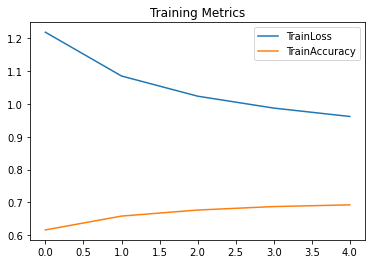

In [178]:
# loss result
plt.plot(model.loss, label = 'TrainLoss')
plt.plot(model.accuracy, label = 'TrainAccuracy')
plt.title('Training Metrics')
plt.legend()
plt.show()

### NOTE:
**Stride is not implemented!**